In [3]:
import sys
import os
sys.path.append(os.path.abspath('../..'))

from spectraldcd.alg.spectral_geodesic_smoothing import spectral_geodesic_smoothing
from spectraldcd.experiments.dyn_graph_benchmarks import apply_tnetwork_alg
from spectraldcd.visualization.metric_plotting import plot_with_error_bars_multiple_metrics
import tnetwork as tn
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sp

# Some helper functions


In [5]:
def tn_format_int_into_node_key(num):
    return f'n_t_{num // 10000:0>4}_{num % 10000:0>4}'

def tn_benchmark_generated_communities_to_labels_list(generated_network, generated_communities, num_nodes):
    T = generated_network.end()

    generated_communities_snapshots = generated_communities.to_DynCommunitiesSN(slices=1)
       
    node_keys = [tn_format_int_into_node_key(i) for i in range(num_nodes)]
    labels_list = []

    # assuming no community overlap
    for t in range(T):
        print(t)
        affiliations = generated_communities_snapshots.snapshot_affiliations(t=t)
        affiliations_list_indexed_by_node= []
        for node_key in node_keys:
            if node_key in affiliations:
                affiliations_list_indexed_by_node.append(affiliations[node_key])
            else:
                affiliations_list_indexed_by_node.append(None)
        labels = [int(list(affiliations_list_indexed_by_node[i])[0]) if affiliations_list_indexed_by_node[i] is not None else None for i in range(num_nodes)]
        labels_list.append(labels)
        
    print(np.array(labels_list).shape)
    return labels_list, node_keys

def get_adjacencies_and_truths(tn_dynamic_network, tn_communities):
    T = tn_dynamic_network.end()
    tn_dynamic_network_SN = tn_dynamic_network.to_DynGraphSN(slices=1)
    comms_snapshots = tn_communities.to_DynCommunitiesSN(slices=1)
    
    sorted_node_ids = sorted(tn_dynamic_network_SN.graph_at_time(0).nodes())
    
    adjacency_matrices = [nx.adjacency_matrix(tn_dynamic_network_SN.graph_at_time(t), nodelist=sorted_node_ids).toarray() for t in range(T)]
    labels_list, _ = tn_benchmark_generated_communities_to_labels_list(tn_dynamic_network, tn_communities, adjacency_matrices[0].shape[0])

    return adjacency_matrices, labels_list, comms_snapshots

# Data creation function
Using the `tnetwork` library, we will simulate a dynamic network where, over time, the number of communities shrinks from eight to six.

In [6]:
def eight_comms_merge_into_six(show=True, noise=0.7):
    my_scenario = tn.ComScenario(random_noise=noise)
    size = 15
    com0,com1, com2, com3, com4, com5, com6, com7 = my_scenario.INITIALIZE([size]*8,["0","1", "2", "3", "4", "5", "6", "7"])
    my_scenario.CONTINUE(com7, delay=1)
    merge1 = my_scenario.MERGE([com0,com1],"0", delay=35)
    merge5 = my_scenario.MERGE([com5,com6],"5", delay=35)
    
    my_scenario.CONTINUE(merge1, delay=40)
    my_scenario.CONTINUE(merge5, delay=40)
    generated_network, generated_communities = my_scenario.run()

    tn.plot_longitudinal(generated_network,generated_communities,height=264, width=528)
    plt.xlabel("$t_i$", labelpad=-10, x=1.02)
    plt.gcf().set_size_inches(5.5/2, 5.5/3)  # Change these numbers to your desired width and height
    plt.savefig("eight_comms_merge_into_six.pdf", transparent=True)
    plt.show() if show else None
    
    adjacency_matrices, labels_list, comms_snapshots = get_adjacencies_and_truths(generated_network, generated_communities)
    
    return adjacency_matrices, labels_list, comms_snapshots

# Benchmarking 

In [7]:
def benchmark(adjacency_matrices, labels_true, k_max, tnetwork_dcd_fns, tnetwork_dcd_fn_names):
    figsize = (10, 8)
    
    T = len(adjacency_matrices)
    d = np.shape(adjacency_matrices[0])[0]
    print(tnetwork_dcd_fn_names)
    leg_labels = ["Geodesic Spectral Clustering"]
    for tnetwork_dcd_fn_name in tnetwork_dcd_fn_names:
        if tnetwork_dcd_fn_name == "label_smoothing":
            leg_labels.append("Label Smoothing")
        elif tnetwork_dcd_fn_name == "smoothed_graph":
            leg_labels.append("Smoothed Graph")
        elif tnetwork_dcd_fn_name == "smoothed_louvain":
            leg_labels.append("Smoothed Louvain")
    
    
    labels_pred_all_benchmarks = []
    labels_pred_all_benchmarks_adjusted_for_omitted_truths = []
    Nones_removed_labels_pred_adjusted_for_omitted_truths_all_benchmarks = []
    
    start = time.time()
    
    # convert adjacency matrices to sparse matrices
    adjacency_matrices_sparse = [sp.csr_matrix(A) for A in adjacency_matrices]
    geodesic_labels_pred_sgs, embeddings_list_sgs = spectral_geodesic_smoothing(adjacency_matrices_sparse, T=T, num_nodes=d, ke=k_max, stable_communities=False, mode='simple-nsc', smoothing_filter='median', smoothing_parameter=11)
    print("Time taken for spectral geodesic smoothing: ", time.time() - start)
    labels_pred_all_benchmarks.append(geodesic_labels_pred_sgs)
    #print("geodesic number of communities found over time", [len(np.unique(labels)) for labels in geodesic_labels_pred_sgs])
    
    for i, tnetwork_dcd_fn in enumerate(tnetwork_dcd_fns):
        _, labels_pred = apply_tnetwork_alg(adjacency_matrices, tnetwork_dcd_fn)
        labels_pred_all_benchmarks.append(labels_pred)
    
    for i, labels_pred in enumerate(labels_pred_all_benchmarks):
        labels_pred_adjusted_for_omitted_truth = []
        for t in range(T):
            labels_pred_adjusted_for_omitted_truth.append([labels_pred[t][i] if labels_true[t][i] is not None else None for i in range(d)])
        labels_pred_all_benchmarks_adjusted_for_omitted_truths.append(labels_pred_adjusted_for_omitted_truth)
    
    for i, labels_pred_adjusted_for_omitted_truth in enumerate(labels_pred_all_benchmarks_adjusted_for_omitted_truths):
        Nones_removed_labels_pred_adjusted_for_omitted_truth = [list(filter(lambda x: x is not None, labels_pred_all_benchmarks_adjusted_for_omitted_truths[i][t])) for t in range(T)]
        Nones_removed_labels_pred_adjusted_for_omitted_truths_all_benchmarks.append(Nones_removed_labels_pred_adjusted_for_omitted_truth)
        
    Nones_removed_labels_true = [list(filter(lambda x: x is not None, labels_true[t])) for t in range(T)]
    
    preprocessed = [[n] for n in Nones_removed_labels_pred_adjusted_for_omitted_truths_all_benchmarks]
    plot_with_error_bars_multiple_metrics(preprocessed, [Nones_removed_labels_true], leg_labels, metrics=['ami'], figuresize=figsize, output_file="output.pdf", ribbons=False, long_data=True)


In [10]:
# choose algs to benchmark against
tn_algs = (tn.DCD.label_smoothing,  tn.DCD.smoothed_graph, tn.DCD.smoothed_louvain)
tn_alg_names = ["label_smoothing", "smoothed_graph", "smoothed_louvain"]

adjacency_matrices, labels_true, comms_snapshots = eight_comms_merge_into_six(show=True)
benchmark(adjacency_matrices, labels_true, 8, tn_algs, tn_alg_names)



  0% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--


KeyboardInterrupt: 

# Synthetic Benchmarks

making graph for time step  0
making graph for time step  1
making graph for time step  2
making graph for time step  3
making graph for time step  4
making graph for time step  5
making graph for time step  6
making graph for time step  7
making graph for time step  8
making graph for time step  9
making graph for time step  10
making graph for time step  11
making graph for time step  12
making graph for time step  13
making graph for time step  14
making graph for time step  15
making graph for time step  16
making graph for time step  17
making graph for time step  18
making graph for time step  19
making graph for time step  20
making graph for time step  21
making graph for time step  22
making graph for time step  23
making graph for time step  24
making graph for time step  25
making graph for time step  26
making graph for time step  27
making graph for time step  28
making graph for time step  29
making graph for time step  30
making graph for time step  31
making graph for t

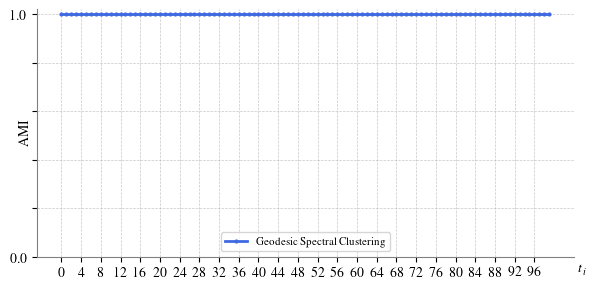

In [63]:
from spectraldcd.experiments.dynamic_simplesbm import sbm_dynamic_model_2
from spectraldcd.alg.spectral_geodesic_smoothing import spectral_geodesic_smoothing
from spectraldcd.experiments.dyn_graph_benchmarks import apply_tnetwork_alg
import tnetwork as tn


d = 1000 # VERIFIED
T = 100 # VERIFIED
k = 5 # VERIFIED
pin = 0.3
pout = 0.2
p_switch = 1 / (10*T)
num_sims = 1
base_seed = 4

# Generate synthetic data
adjacency_all, true_labels_all = sbm_dynamic_model_2(N=int(d), k=k, pin=[pin]*k, pout=pout, p_switch=p_switch, T=int(T), Totalsims=num_sims, base_seed=base_seed, try_sparse=True)

# Convert true_labels_all from (Totalsims, T, N) to list of lists
true_labels_list = [true_labels_all[sim] for sim in range(true_labels_all.shape[0])]

# Convert adjacency matrices to dense for tnetwork algorithms
adjacency_all_dense = [[adj.toarray() for adj in sim_adjacencies] for sim_adjacencies in adjacency_all]

# Run spectral geodesic smoothing
predicted_labels_all = []
for sim_adjacencies in adjacency_all:
    T = len(sim_adjacencies)
    predicted_labels, _ = spectral_geodesic_smoothing(sim_adjacencies, T=T, num_nodes=d, ke=k, stable_communities=True, mode='simple-nsc', smoothing_filter='median', smoothing_parameter=T // 10 + 1)
    predicted_labels_all.append(predicted_labels)

# Run tnetwork benchmark algorithms
tn_algs = (tn.DCD.label_smoothing, tn.DCD.smoothed_graph, tn.DCD.smoothed_louvain)
tn_alg_names = ["label_smoothing", "smoothed_graph", "smoothed_louvain"]

all_predicted_labels = [predicted_labels_all]
leg_labels = ['Geodesic Spectral Clustering']

#for i, tnetwork_dcd_fn in enumerate(tn_algs):
#    tn_predicted_labels_all = []
#    for sim_adjacencies in adjacency_all_dense:
#        _, labels_pred = apply_tnetwork_alg(sim_adjacencies, tnetwork_dcd_fn)
#        tn_predicted_labels_all.append(labels_pred)
#    all_predicted_labels.append(tn_predicted_labels_all)
#    if tn_alg_names[i] == "label_smoothing":
#        leg_labels.append("Label Smoothing")
#    elif tn_alg_names[i] == "smoothed_graph":
#        leg_labels.append("Smoothed Graph")
#    elif tn_alg_names[i] == "smoothed_louvain":
#        leg_labels.append("Smoothed Louvain")

# Plot the results
plot_with_error_bars_multiple_metrics(all_predicted_labels, true_labels_list, leg_labels, metrics=['ami'], ribbons=True)

100 100
(1000, 1000)
M1 symmetric: True
MT symmetric: True
Converged in 40 iterations
Time to get geodesic embeddings: 9.465627193450928
kc_list: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Using constant kc_list
Plotting metric: ami
For algorithm: Geodesic Spectral Clustering
Computing metric for simulation 1...
metric: AMI


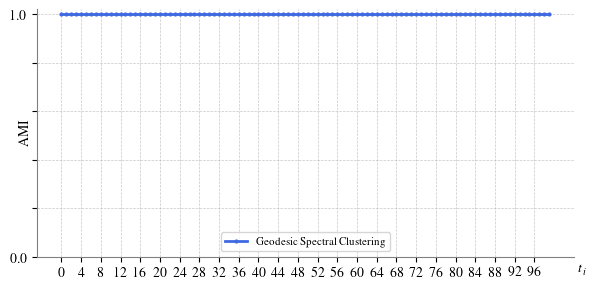

In [33]:
import pickle

folder = "/Users/jacobhume/OneDrive/School/FA2025/SPADA/spectral-dcd/spectraldcd/experiments"
d = 1000
T = 100

with open(os.path.join(folder, f"geodesic_nsc_adj_matrices_{d}_{T}.pkl"), "rb") as f:
    adj_matrices_all = pickle.load(f)

with open(os.path.join(folder, f"geodesic_nsc_true_assignments_{d}_{T}.pkl"), "rb") as f:
    true_assignments_all = pickle.load(f)
    
# apply geodesic spectral clustering
print(len(adj_matrices_all), len(true_assignments_all))
print(np.shape(adj_matrices_all[0]))
predicted_labels_all = []
k = 5  # Define k




predicted_labels, _ = spectral_geodesic_smoothing(adj_matrices_all, T=T, num_nodes=d, ke=k, stable_communities=True, mode='simple-nsc', smoothing_filter='median', smoothing_parameter=T // 10 + 1)
predicted_labels_all.append(predicted_labels)
    
all_predicted_labels = [predicted_labels_all]
leg_labels = ['Geodesic Spectral Clustering']

plot_with_error_bars_multiple_metrics(all_predicted_labels, [true_assignments_all], leg_labels, metrics=['ami'], ribbons=True)

# Visualizing embeddings

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba, to_hex
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
import matplotlib as mpl
mpl.rcParams.update({
    'savefig.transparent': True,
    'figure.facecolor': 'none',
    'axes.facecolor': 'none',
})


# --- Helper function to generate washed-out colors ---
def _make_color_washed_out(hex_color, factor=0.6, alpha=0.5):
    """
    Mixes a color with white to make it appear "washed out" or pastel.

    Args:
        hex_color (str): The starting color in hex format (e.g., '#1f77b4').
        factor (float): The mixing factor. 0.0 is pure white, 1.0 is the original color.
        alpha (float): The transparency of the final color.

    Returns:
        tuple: An RGBA color tuple (r, g, b, a).
    """
    rgb_color = np.array(to_rgba(hex_color)[:3])
    white = np.array([1.0, 1.0, 1.0])
    mixed_rgb = rgb_color * factor + white * (1 - factor)
    return (*mixed_rgb, alpha)

# --- Refactored plotting function ---
def _create_and_style_plot(
    fig, ax, T, d, embeddings_over_time, labels_true_array,
    full_color_map, washed_color_map, legend_handles,
    save_path=None
):
    """
    Internal helper function to generate and style a single trajectory plot.
    """
    # Loop over each node to create its trajectory
    for n in range(d):
        x = np.arange(T)
        y = embeddings_over_time[:, n]
        
        # Create segments: a list of ((x1, y1), (x2, y2)) coordinates
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        # --- Logic for transitions and washed-out colors ---
        segment_colors = []
        segment_linewidths = []
        segment_zorders = []

        for t in range(T - 1):
            label_now = labels_true_array[t, n]
            label_next = labels_true_array[t + 1, n]

            if label_now == label_next:
                # No transition: use washed-out color and standard line
                segment_colors.append(washed_color_map[label_now])
                segment_linewidths.append(1.0)
                segment_zorders.append(1) # Draw in the background
            else:
                # Transition: use full color of the *new* community and a thick line
                segment_colors.append(full_color_map[label_next])
                segment_linewidths.append(2.5)
                segment_zorders.append(5) # Draw on top

        # Create a LineCollection with varied colors, widths, and z-orders
        lc = LineCollection(segments, colors=segment_colors, linewidths=segment_linewidths, zorder=1)
        # Note: The zorder for individual segments is not directly supported in all backends.
        # We achieve the effect by plotting high-zorder lines on top later if needed,
        # but in most cases, the difference in width and color is sufficient.
        # For simplicity and broad compatibility, we set a base zorder here. The visual
        # effect is primarily driven by color and width.
        ax.add_collection(lc)

    # --- Aesthetics and Styling ---
    ax.set_xlim(0, T - 1)
    ax.set_ylim(embeddings_over_time.min(), embeddings_over_time.max())

    ax.set_xlabel("$t$", fontsize=14)

    # Remove tick labels while keeping axis limits
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    #ax.legend(handles=legend_handles, title="Community", loc='best', frameon=True, fancybox=True, shadow=True)
    
    # Remove top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Optional: Finer grid control
    ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

    # Set transparent background
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')

    # --- Save Figure ---
    if save_path:
        print(f"Saving figure to '{save_path}'...")
        
        fig.patch.set_facecolor('none')
        ax.patch.set_facecolor('none')
        try:
            fig.savefig(
                save_path,
                format='pdf',
                transparent=True,
                bbox_inches='tight',
                pad_inches=0.05,
                facecolor='none'
            )
            print("Save successful.")
        except Exception as e:
            print(f"Error saving figure: {e}")


# --- Main plotting function (modified) ---
def plot_1d_temporal_trajectories(
    adjacency_matrices_sparse,
    labels_true,
    T,
    d,
    save_path_plot1=None,
    save_path_plot2=None
):
    """
    Generates and displays two visualizations of 1D temporal trajectories,
    highlighting community transitions.

    Args:
        adjacency_matrices_sparse (list): List of sparse adjacency matrices.
        labels_true (list of lists): Node community labels over time.
        T (int): Number of time steps.
        d (int): Number of nodes.
        save_path_plot1 (str, optional): File path to save the first plot as a PDF. Defaults to None.
        save_path_plot2 (str, optional): File path to save the second plot as a PDF. Defaults to None.
    """
    #plt.style.use('seaborn-v0_8-whitegrid') # Apply a nice style

    # --- 1. Setup Colors and Labels ---
    base_colors = [
        '#86cdeb', '#fe7f72', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#bcbd22', '#17becf'
    ]
    gray_color_rgba = (0.7, 0.7, 0.7, 0.5)
    gray_color_hex = '#b3b3b3'

    labels_true_array = np.array(labels_true, dtype=object)
    
    all_labels_flat = [label for row in labels_true for label in row if label is not None]
    community_labels = sorted(list(set(all_labels_flat)))

    # Create mappings for full and washed-out colors
    full_color_map = {label: base_colors[i % len(base_colors)] for i, label in enumerate(community_labels)}
    washed_color_map = {label: _make_color_washed_out(color) for label, color in full_color_map.items()}

    # Handle 'None' label (no community) separately
    if any(None in row for row in labels_true):
        full_color_map[None] = gray_color_hex
        washed_color_map[None] = gray_color_rgba

    # --- 2. Create Legend Handles (shared by both plots) ---
    legend_handles = []
    for label in community_labels:
        legend_handles.append(plt.Line2D(
            [0], [0], color=full_color_map[label], marker='o', linestyle='',
            markersize=8, label=f'Community {label}'
        ))
    if None in full_color_map:
        legend_handles.append(plt.Line2D(
            [0], [0], color=full_color_map[None], marker='o', linestyle='',
            markersize=8, label='No Community'
        ))

    # --- 3. Plot 1: Geodesic Approach ---
    print("\nComputing 2D geodesic embeddings...")
    geo_embeddings_list_2d = spectral_geodesic_smoothing(
        adjacency_matrices_sparse, T=T, num_nodes=d, ke=2,
        mode='simple-nsc', return_geo_embeddings_only=True
    )
    geo_embeddings_over_time = np.array([emb[:, 1] for emb in geo_embeddings_list_2d])

    fig1, ax1 = plt.subplots(figsize=(16, 9))
    _create_and_style_plot(
        fig=fig1, ax=ax1, T=T, d=d,
        embeddings_over_time=geo_embeddings_over_time,
        labels_true_array=labels_true_array,
        full_color_map=full_color_map,
        washed_color_map=washed_color_map,
        legend_handles=legend_handles,
        save_path=save_path_plot1
    )
    plt.show()

    # --- 4. Plot 2: Independent Laplacian Eigenmaps ---
    print("\nComputing 2D Independent Laplacian Eigenmaps...")
    
    def normalized_signless_laplacian(A):
        degrees = A.sum(axis=1).A1
        with np.errstate(divide='ignore', invalid='ignore'):
            D_inv_sqrt = 1.0 / np.sqrt(degrees)
        D_inv_sqrt[np.isinf(D_inv_sqrt) | np.isnan(D_inv_sqrt)] = 0
        D_inv_sqrt_matrix = sp.diags(D_inv_sqrt)
        D_plus_A = sp.diags(degrees) + A
        return D_inv_sqrt_matrix @ D_plus_A @ D_inv_sqrt_matrix

    independent_embeddings_list_1d = []
    for adj_matrix in adjacency_matrices_sparse:
        L_signless = normalized_signless_laplacian(adj_matrix)
        _, eigenvectors = eigsh(L_signless, k=2, which='LM')
        independent_embeddings_list_1d.append(eigenvectors[:, 1])

    indep_embeddings_over_time = np.array(independent_embeddings_list_1d)

    fig2, ax2 = plt.subplots(figsize=(16, 9))
    _create_and_style_plot(
        fig=fig2, ax=ax2, T=T, d=d,
        embeddings_over_time=indep_embeddings_over_time,
        labels_true_array=labels_true_array,
        full_color_map=full_color_map,
        washed_color_map=washed_color_map,
        legend_handles=legend_handles,
        save_path=save_path_plot2
    )
    plt.show()

Generating synthetic temporal graph data...
making graph for time step  0
making graph for time step  1
making graph for time step  2
making graph for time step  3
making graph for time step  4
making graph for time step  5
making graph for time step  6
making graph for time step  7
making graph for time step  8
making graph for time step  9
making graph for time step  10
making graph for time step  11
making graph for time step  12
making graph for time step  13
making graph for time step  14
making graph for time step  15
making graph for time step  16
making graph for time step  17
making graph for time step  18
making graph for time step  19
making graph for time step  20
making graph for time step  21
making graph for time step  22
making graph for time step  23
making graph for time step  24
making graph for time step  25
making graph for time step  26
making graph for time step  27
making graph for time step  28
making graph for time step  29
making graph for time step  30
makin

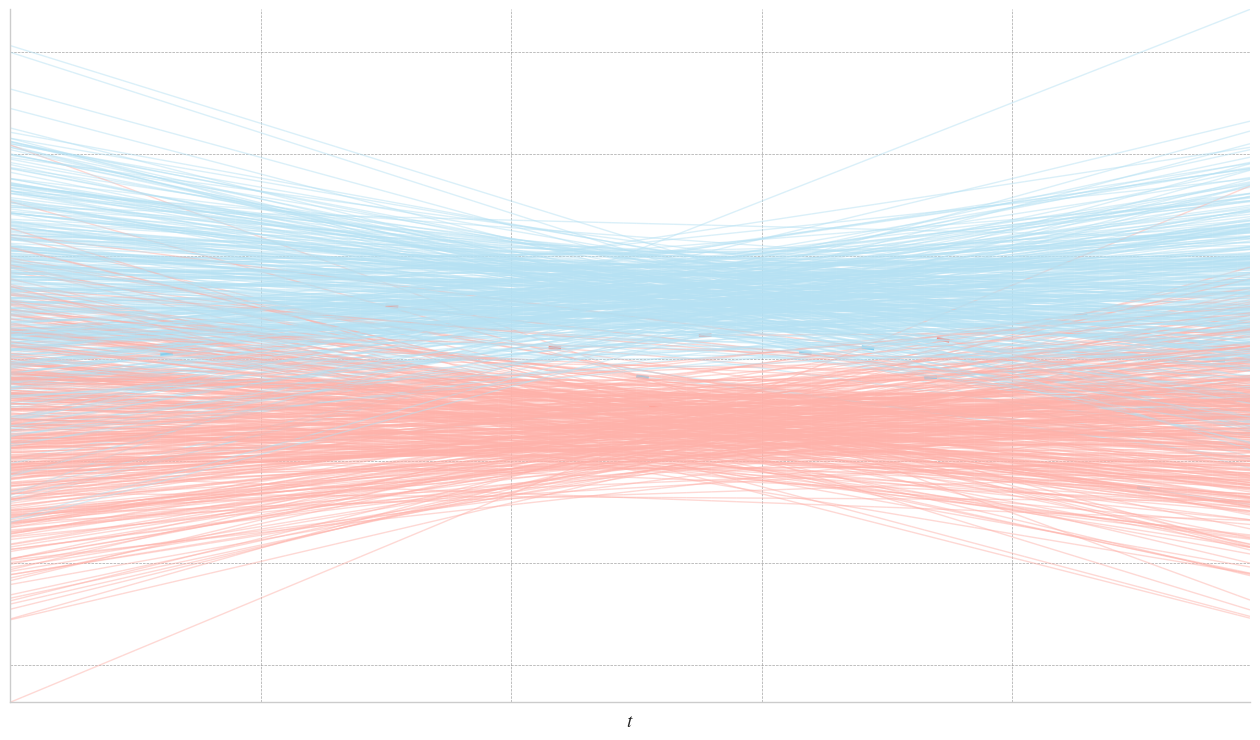


Computing 2D Independent Laplacian Eigenmaps...
Saving figure to 'independent_eigenmaps_trajectories.pdf'...
Save successful.


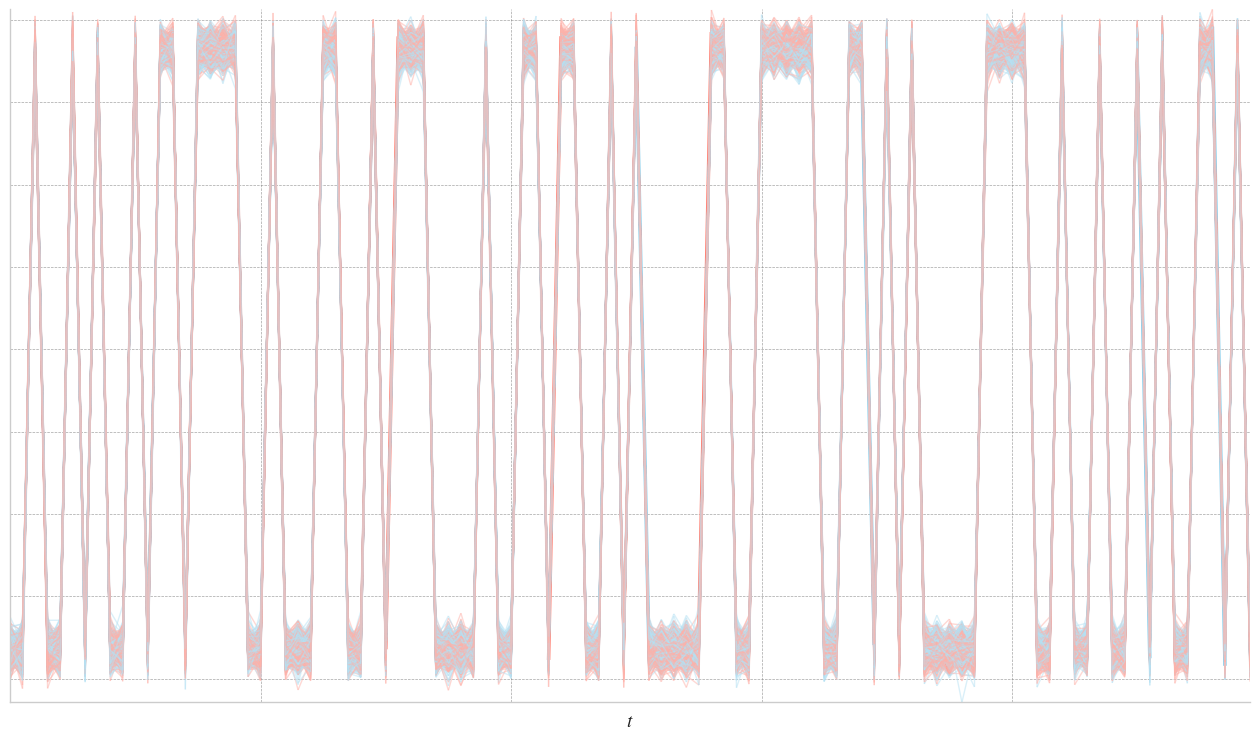

In [132]:



print("Generating synthetic temporal graph data...")
d = 750
T = 100
k = 2
pin = 0.3
pout = 0.1
p_switch = 0.02

adjacency_all, true_labels_all = sbm_dynamic_model_2(
    N=d, k=k, pin=[pin]*k, pout=pout, p_switch=p_switch, T=T, Totalsims=1, base_seed=4, try_sparse=True
)
adjacency_matrices_sparse = adjacency_all[0]
labels_true = true_labels_all[0]

save_path_plot1 = "geodesic_trajectories.pdf"
save_path_plot2 = "independent_eigenmaps_trajectories.pdf"

plot_1d_temporal_trajectories(adjacency_matrices_sparse, labels_true, T, d, save_path_plot1=save_path_plot1, save_path_plot2=save_path_plot2)

# use tnetwork instead 


  0% (0 of 5) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--
 40% (2 of 5) |##########                | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (4 of 5) |####################      | Elapsed Time: 0:00:01 ETA:   0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:01 ETA:  00:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:02 ETA:  00:00:00


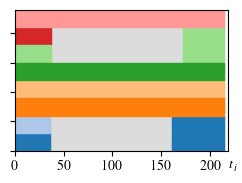

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
(214, 120)
=== DEBUG COLOR MAPPING ===
Sample labels_true (first 3 timesteps): [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

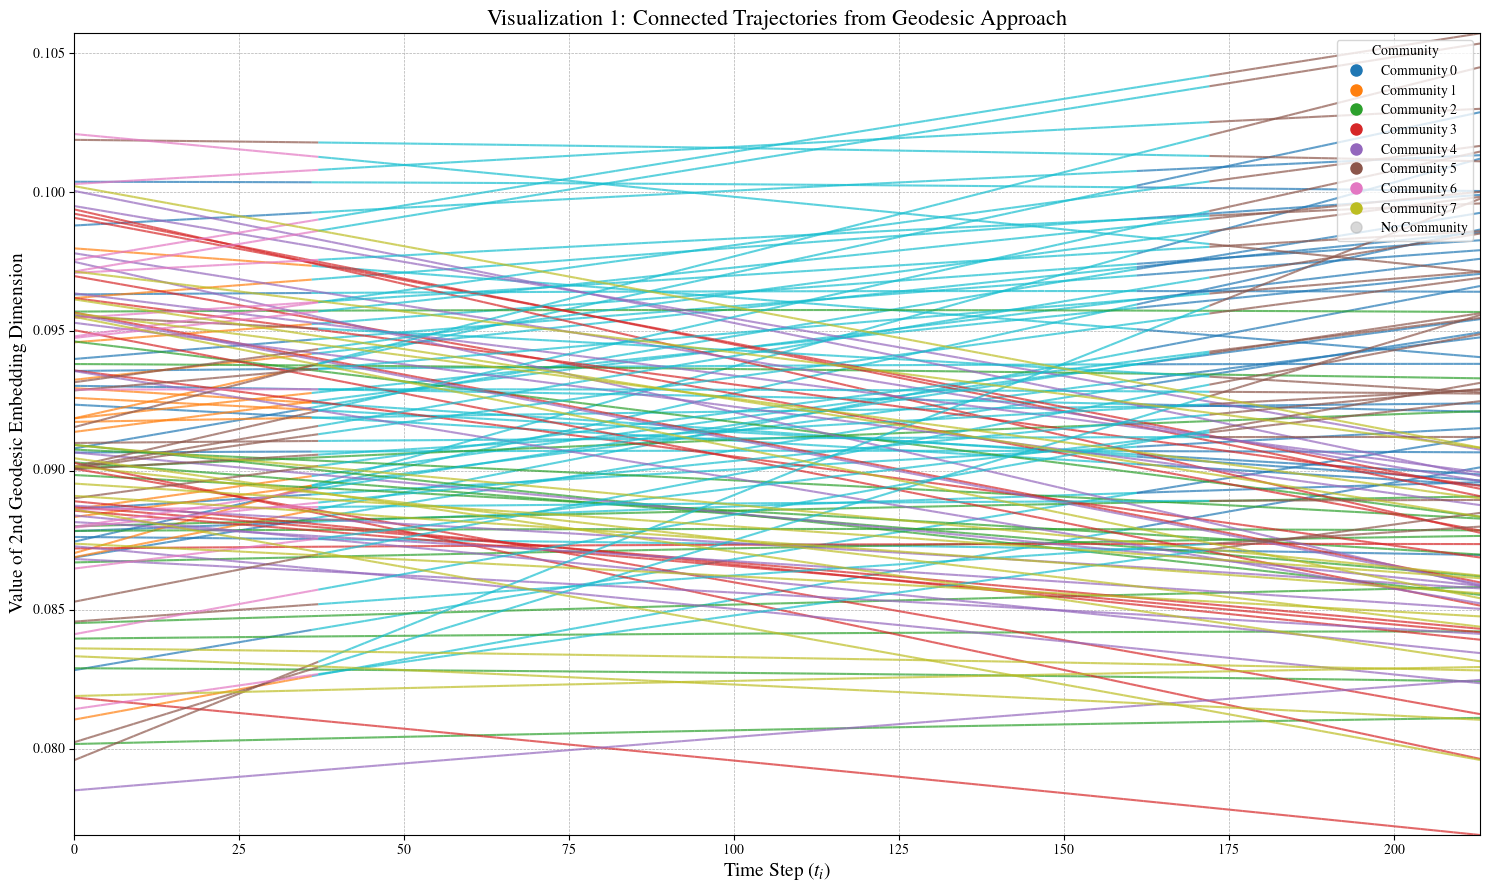


Computing 2D Independent Laplacian Eigenmaps for the second plot...
Processing and generating visualization for the Independent approach...


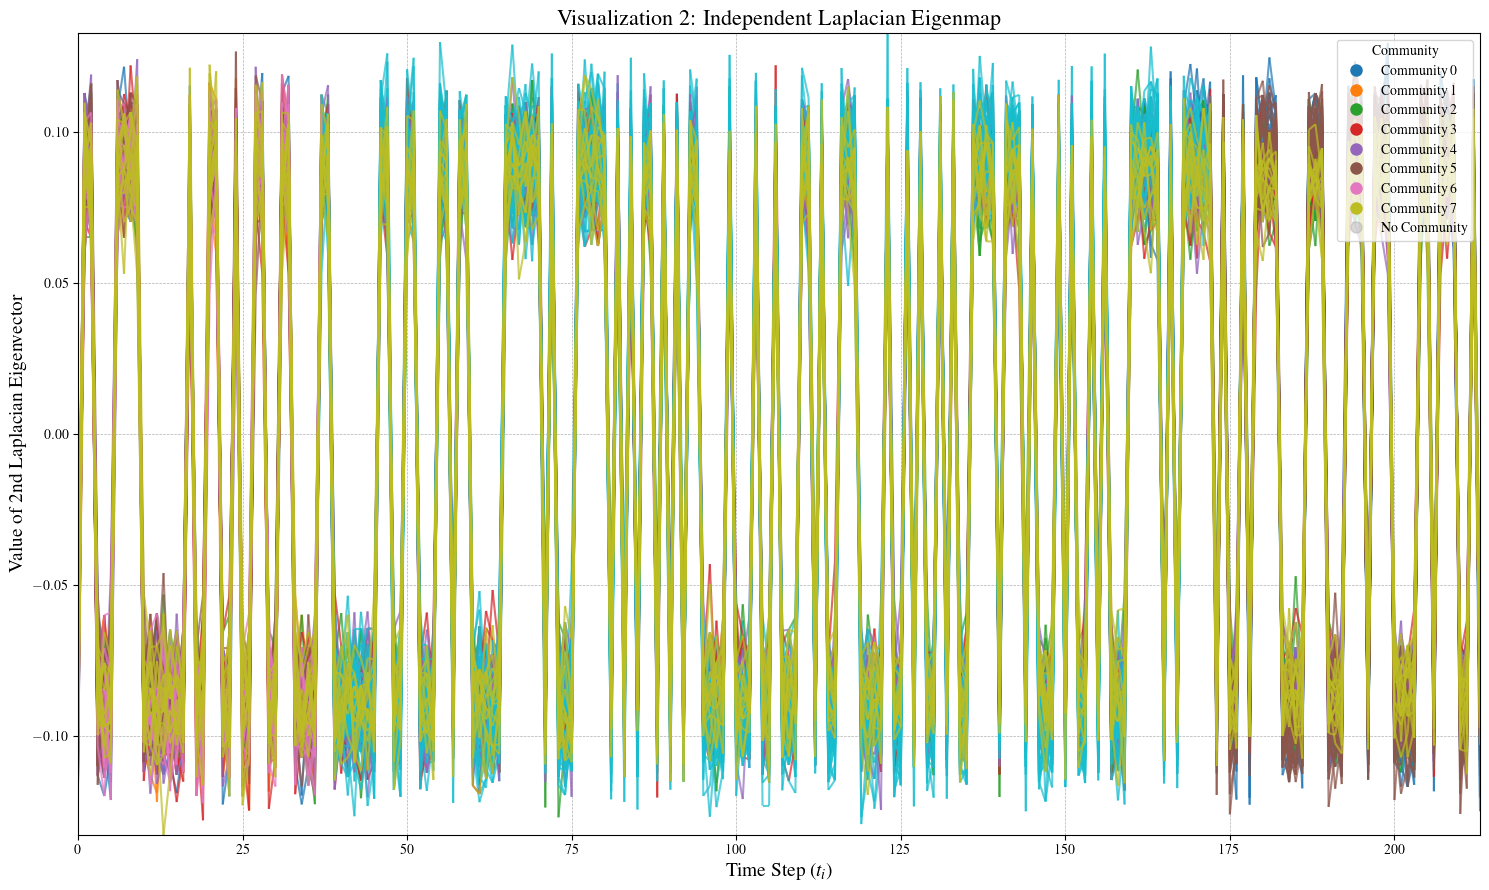

In [96]:


# tnetwork synthetic data
noise = 0.7
adjacency_matrices, labels_true, comms_snapshots = eight_comms_merge_into_six(show=True, noise=noise)

# Convert dense matrices to sparse format
adjacency_matrices_sparse = [sp.csr_matrix(adj) for adj in adjacency_matrices]

# Call the function with sparse matrices
plot_1d_temporal_trajectories(adjacency_matrices_sparse, labels_true, len(adjacency_matrices), adjacency_matrices[0].shape[0])